## 0. API 이용해 시계열 데이터 불러오기

DataReader() 함수를 사용해 yahoo finance 에서 금융 시계열 데이터를 불러온다. <br>
금융 시장에 존재하는 모든 가격패턴을 얻기 위해 다양한 자산의 ETF가격 데이터를 활용한다. <br>

In [110]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date


tickers = ["DBC", "DBA", "LQD", "TLT", "TIP", "XLB", "XLE", "SHY", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"]
price_all = {}
start_date = "1950-01-02"
end_date = date.today()
for t in tickers:
  price_table = web.DataReader(t, "yahoo", start_date, end_date)
  price_all[t] = price_table["Close"]

# price_all["DBA"].plot()
# price_all["DBC"]

## 1. Functional Data Anlaysis로 금융 시장에 존재하는 가격패턴 분류


### 1.1 FDA 는 무엇인가?

### 1.2 금융시장에 존재하는 패턴 분류

#### 1.2.1 가격 패턴 데이터 만들기

다양한 금융시장 환경에서 존재하는 가격 패턴의 전체 집합을 만들기 위해 주식, 채권, 원자재 등 다양한 자산에 대해 12개월의 가격 데이터를 여러 구간별로 나누어서 만든다. <br>



##### **결측값 handling**
1. 자산별 비어있는 날짜의 데이터는 이전의 값으로 채운다.
2. ETF 상품별 시작일이 다르다. 동일한 시기에 존재하는 패턴 비교를 위해 길이가 가장 짧은 ETF를 기준으로 한다.

In [111]:
# Merge time series data frame
etf_price_df = pd.concat(price_all, axis=1, keys=tickers, join="outer")
filna_df = etf_price_df.fillna(method="ffill")
dropna_df = filna_df.dropna()
raw_price = dropna_df #dropna_df: original data
raw_price.head()

,DBC,DBA,LQD,TLT,TIP,XLB,XLE,SHY,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,
2007-01-05,23.100000,25.02,107.180000,89.209999,99.019997,34.220001,55.919998,80.070000,29.658813,34.959999,23.500000,26.139999,36.110001,33.689999,38.250000
2007-01-08,23.219999,24.98,107.150002,89.370003,99.089996,34.220001,55.919998,80.019997,29.788790,35.090000,23.570000,26.180000,36.090000,33.730000,38.310001
2007-01-09,23.020000,24.66,107.169998,89.370003,99.019997,34.230000,55.439999,80.050003,29.740049,35.070000,23.600000,26.240000,36.119999,33.689999,38.520000
2007-01-10,22.680000,24.73,107.029999,88.970001,98.769997,34.470001,54.369999,80.029999,29.837530,35.189999,23.719999,26.350000,36.130001,33.750000,38.720001
2007-01-11,22.650000,25.10,106.699997,88.449997,98.440002,34.840000,54.060001,79.970001,30.024370,35.480000,23.959999,26.549999,36.169998,34.119999,39.150002


##### **가격 스케일링**
각 ETF별 변동성이 달라 raw 데이터로 패턴 분류 시 변동성이 영향을 줄 수 있다. 가격 패턴만을 분류하는 것이 목적이기 때문에 가격의 상승 하락 폭을 동일하게 하기 위해 스케일링 한다. 또한 시계열이 길어질수록 값이 기하 급수적으로 증가하기 때문에 로그 스케일의 가격 데이터를 사용한다.

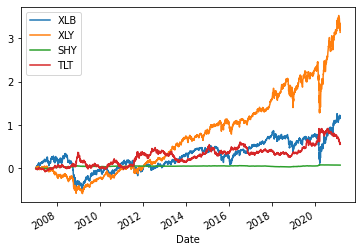

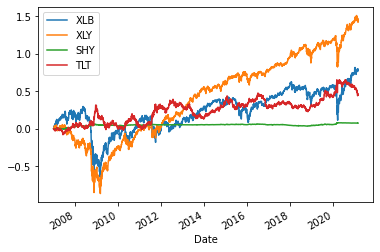

In [113]:
price = raw_price / raw_price.iloc[0] - 1
log_scaled_price = np.log(raw_price / raw_price.iloc[0])

price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()
log_scaled_price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()

동일한 기준에서 패턴 분류를 위해 각 자산의 가격 데이터를 정규화한다. <br>

scaled_price = (log price - mean log price) / sd(log price)

12개월의 가격데이터로 패턴을 분류할 것이기 때문에 평균과 분산은 1년을 기준으로 한다.

In [102]:
# Mean
annual_return = log_scaled_price.pct_change(periods=252)
annual_return = annual_return.dropna()
use_idx = [i for i in range(len(annual_return)) if (i%21 == 0)]
annual_std = monthly_return.iloc[use_idx,:].std() * (12) ** (1/2)

# use_idx = [i for i in range(len(monthly_return)) if (i%21 == 0)]
# annual_std = monthly_return.iloc[use_idx,:].std() * (12) ** (1/2)

# annual_std

DBC    0.209439
DBA    0.179674
LQD    0.081262
TLT    0.133267
TIP    0.055620
XLB    0.231261
XLE    0.270910
SHY    0.012367
XLF    0.300663
XLI    0.228402
XLK    0.197207
XLP    0.126650
XLU    0.161162
XLV    0.151187
XLY    0.205611
dtype: float64

연율화된 변동성으로 가격을 나눠준다. 그리고 plot을 그리면 자산별 변동성이 제거된 가격패턴을 볼 수 있다.

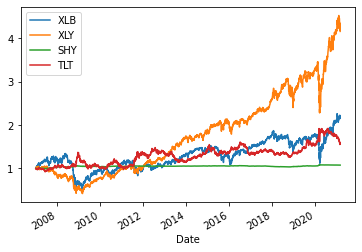

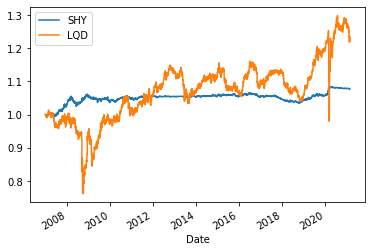

In [108]:
std_scaled_price = raw_price / (1+annual_std)
std_scaled_price = std_scaled_price / std_scaled_price.iloc[0]

std_scaled_price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()
std_scaled_price.loc[:, ["SHY", "LQD"]].plot()

## 2. Frog in the pan 참고자료를 통해 각 패턴의 향후 수익 지속성 및 한달 후 수익 결과 확인

### 2.1 frog in the pan 첨부해 간략히 어떤 내용인지 설명

### 2.2 위에서 클러스터링 한 패턴들의 향후 1달 수익률 및 수익을 지속하는 평균 개월수 구한다.